# Ex 1

In [1]:
import scipy.optimize, numpy.random

def f(x):
    return x**2

def df(x):
    return 2*x

In [2]:
%time
print(scipy.optimize.minimize(f, numpy.random.randint(-1000, 1000), jac=df))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
      fun: 8.077935669463161e-28
 hess_inv: array([[0.5]])
      jac: array([5.68434189e-14])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([2.84217094e-14])


In [3]:
%time
print(scipy.optimize.minimize(f, numpy.random.randint(-1000, 1000), jac=False))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
      fun: 5.43852184854248e-17
 hess_inv: array([[0.49999992]])
      jac: array([1.51894299e-10])
  message: 'Optimization terminated successfully.'
     nfev: 16
      nit: 4
     njev: 8
   status: 0
  success: True
        x: array([-7.37463345e-09])


## Answer Ex 1

The variant specified with jac works faster and handles the task in fewer steps

# Ex 2

In [4]:
import numpy as np

In [5]:
def hinge_loss_surrogate(y_gold, y_pred):
    return max(0, 1 - y_gold * y_pred)

In [6]:
def svm_loss(w, b, C, D):
    loss = 0
    for row in D:        
        loss += hinge_loss_surrogate(row[1], np.dot(w, row[0]) + b)    
    return 0.5 * np.dot(w, w) + C * loss

# Ex 3

In [16]:
def svm(D, C=1):
    w = np.zeros(len(D[0][0]))
    b = np.array([0])
    svm_loss_with_params = lambda w_b: svm_loss(w=w_b[:-1], b=w_b[-1], C=C, D=D)
    svm_result = scipy.optimize.minimize(svm_loss_with_params,
                                         x0 = np.concatenate([w, b]),
                                         jac=False).x
    w, b = svm_result[:-1], svm_result[-1]
    return w, b    

# Ex 4

In [8]:
def gradient_hinge_loss_surrogate(y_gold, y_pred):
    if hinge_loss_surrogate(y_gold, y_pred) == 0:
        return 0
    else:
        return -y_gold


def gradient_svm_loss(w, b, C, D):
    d_w = w + C*sum([row[0]*gradient_hinge_loss_surrogate(row[1], numpy.dot(row[0], w) + b) for row in D])
    d_b = C*sum([gradient_hinge_loss_surrogate(row[1], numpy.dot(row[0], w) + b) for row in D])
    return [*d_w, d_b]

def svm(D, C=1, use_gradient=False):
    w = np.zeros(len(D[0][0]))
    b = np.array([0])
    
    svm_loss_with_params = lambda w_b: svm_loss(w=w_b[:-1], b=w_b[-1], C=C, D=D)
    
    if use_gradient:
        gradient_svm_loss_with_params = lambda w_b: gradient_svm_loss(w=w_b[:-1], b=w_b[-1], C=C, D=D)
        svm_result = scipy.optimize.minimize(svm_loss_with_params,
                                             x0 = np.concatenate([w, b]),
                                             jac=gradient_svm_loss_with_params).x
    else:
        svm_result = scipy.optimize.minimize(svm_loss_with_params,
                                             x0 = np.concatenate([w, b]),
                                             jac=False).x
    
    w, b = svm_result[:-1], svm_result[-1]
    return w, b

# Ex 5

In [9]:
import matplotlib.pyplot as plt

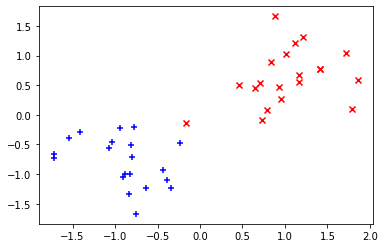

In [10]:
x_plus = numpy.random.normal(loc=[-1,-1], scale=0.5, size=(20,2))
x_minus = numpy.random.normal(loc=[1,1], scale=0.5, size=(20,2))

plt.scatter(
    x_plus[:,0], x_plus[:,1],
    marker='+',
    color='blue'
)
plt.scatter(
    x_minus[:,0], x_minus[:,1],
    marker='x',
    color='red'
)

In [11]:
D = list()

for x in x_plus:
    D.append((x, 1))
    
for x in x_minus:
    D.append((x, -1))

In [12]:
def AveragedPerceptronTrain(D, maxiter = 1000):
    w = np.zeros(len(D[0][0]))
    b = np.zeros(1)
    u = np.zeros(len(D[0][0]))
    beta = 0
    c = 1
    for i in range(maxiter):
        for x, y in D:
            a = np.dot(x, w) + b
            if np.sign(y * a) <= 0: 
                w += y * x
                b += y
                u += y * c * x
                beta += y * c
            c += 1
    return w - (1/c) * u, b - beta * (1/c)

In [13]:
perc_weights, perc_bias = AveragedPerceptronTrain(D)
svm_weights_false, svm_bias_false = svm(D, use_gradient=False)
svm_weights_true, svm_bias_true = svm(D, use_gradient=True)

In [14]:
def get_hyperplane(w, b):
    a = -w[0] / w[1]
    xx = np.linspace(-2.5, 2.5)
    yy = a * xx - (b) / w[1]
    return xx, yy

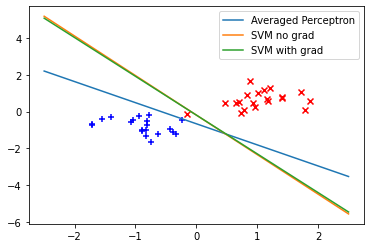

In [15]:
plt.plot(*get_hyperplane(perc_weights, perc_bias), label='Averaged Perceptron')
plt.plot(*get_hyperplane(svm_weights_false, svm_bias_false), label='SVM no grad')
plt.plot(*get_hyperplane(svm_weights_true, svm_bias_true), label='SVM with grad')
plt.scatter(
    x_plus[:,0], x_plus[:,1],
    marker='+',
    color='blue'
)
plt.scatter(
    x_minus[:,0], x_minus[:,1],
    marker='x',
    color='red'
)
plt.legend()
plt.savefig("svm-svm-perceptron.pdf")

You can see that the Perceptron does a better job, but both versions of the SVM are very similar